```python
from pandas import CategoricalDtype, concat, read_csv, DataFrame
from math import floor, log10

_1 = 'DEFEAT', 'DRAW', 'VICTORY'
_2 = {'TEAM': 'uint8', 'ROLE': CategoricalDtype(('TANK', 'DAMAGE', 'SUPPORT')), 'E': 'uint8', 'A': 'uint8',
      'D': 'uint8', 'DMG': 'uint16', 'H': 'uint16', 'MIT': 'uint16'}
_3 = concat((read_csv(f'ROLE/{_4}.csv', index_col=0, dtype=_2) for _4 in _1), keys=_1, names=('RESULT',))
_3.dropna(inplace=True)
_5 = 1, 2
_6 = ('TANK', 1), ('DAMAGE', 2), ('SUPPORT', 2)
_7 = [_8 for _8 in _2 if _8 not in {'TEAM', 'ROLE'}]


def _9(_10):
    _11 = {_12: [] for _12 in _2}
    for _13 in _5:
        _14 = _10[_10['TEAM'] == _13]
        for _15, _16 in _6:
            for _ in range(_16 - sum(_14['ROLE'] == _15)):
                _11['TEAM'].append(_13)
                _11['ROLE'].append(_15)
                for _17 in _7:
                    _11[_17].append(0)
    return DataFrame(_11).astype(_2)


_18 = concat([_3, _3.groupby(level=(0, 1), group_keys=True).apply(_9)])
_18.sort_values(['RESULT', 'INDEX', 'TEAM', 'ROLE'], inplace=True)
_19 = DataFrame()
_19['TEAM'] = _18['TEAM'] - 1
_19['ROLE'] = _18['ROLE'].cat.codes.astype('uint8')
for _20 in _7:
    for _21 in range(floor(log10(_18[_20].max())), -1, -1):
        _19[f'{_20}{_21}'] = (_18[_20] // 10 ** _21 % 10).astype('uint8')

In [1]:
from pandas import CategoricalDtype, concat, read_csv

# Constants
RESULTS = 'DEFEAT', 'DRAW', 'VICTORY'
DTYPES = {
    'TEAM': 'uint8',
    'ROLE': CategoricalDtype(('TANK', 'DAMAGE', 'SUPPORT')),
    'E': 'uint8',
    'A': 'uint8',
    'D': 'uint8',
    'DMG': 'uint16',
    'H': 'uint16',
    'MIT': 'uint16',
}

# Load CSVs and combine into one DataFrame
df = concat(
    (read_csv(f'ROLE/{result}.csv', index_col=0, dtype=DTYPES) for result in RESULTS),
    keys=RESULTS, names=('RESULT',)
)
df

TEAM     ROLE   E   A  D   DMG     H   MIT
RESULT  INDEX                                            
DEFEAT  1         1     TANK   0   0  8  2947  1425  4611
        1         1   DAMAGE   1   0  3  1818     0   650
        1         1   DAMAGE   2   0  7  4735   487   308
        1         1  SUPPORT   1   0  3  2078  2748     0
        1         1  SUPPORT   1   1  3   269  5848   189
...             ...      ...  ..  .. ..   ...   ...   ...
VICTORY 466       2     TANK  17   3  8  7147   351  3898
        466       2   DAMAGE  19   0  9  6344     0   847
        466       2   DAMAGE  26   1  7  9108   150   165
        466       2  SUPPORT   7  22  6  2734  8985     0
        466       2  SUPPORT   5  11  9  1363  4738    45

[9013 rows x 8 columns]

In [2]:
df['ROLE'].unique()

['TANK', 'DAMAGE', 'SUPPORT', NaN]
Categories (3, object): ['TANK', 'DAMAGE', 'SUPPORT']

In [3]:
df.dropna(inplace=True)
df['ROLE'].unique()

['TANK', 'DAMAGE', 'SUPPORT']
Categories (3, object): ['TANK', 'DAMAGE', 'SUPPORT']

In [4]:
df['TEAM'].value_counts()

TEAM
1    4528
2    4484
Name: count, dtype: int64

In [5]:
from pandas import DataFrame

ROLES_PER_TEAM = (
    ('TANK', 1),
    ('DAMAGE', 2),
    ('SUPPORT', 2),
)
STATS = [col for col in DTYPES if col not in {'TEAM', 'ROLE'}]
TEAM_IDS = 1, 2


def fill_missing_roles(group: DataFrame) -> DataFrame:
    """각 팀에 역할별 누락된 데이터를 0으로 채워넣음."""
    filler = {col: [] for col in DTYPES}

    for team_id in TEAM_IDS:
        team_data = group[group['TEAM'] == team_id]
        for role, required_count in ROLES_PER_TEAM:
            current_count = sum(team_data['ROLE'] == role)
            missing_count = required_count - current_count

            for _ in range(missing_count):
                filler['TEAM'].append(team_id)
                filler['ROLE'].append(role)
                for stat in STATS:
                    filler[stat].append(0)

    return DataFrame(filler).astype(DTYPES)


# 누락된 역할 데이터를 채운 후 합치기
df_filled = concat([df, df.groupby(level=(0, 1), group_keys=True).apply(fill_missing_roles)])
df_filled

TEAM     ROLE  E  A  D   DMG     H   MIT
RESULT  INDEX                                          
DEFEAT  1         1     TANK  0  0  8  2947  1425  4611
        1         1   DAMAGE  1  0  3  1818     0   650
        1         1   DAMAGE  2  0  7  4735   487   308
        1         1  SUPPORT  1  0  3  2078  2748     0
        1         1  SUPPORT  1  1  3   269  5848   189
...             ...      ... .. .. ..   ...   ...   ...
VICTORY 396       2     TANK  0  0  0     0     0     0
        396       2   DAMAGE  0  0  0     0     0     0
        396       2   DAMAGE  0  0  0     0     0     0
        396       2  SUPPORT  0  0  0     0     0     0
        396       2  SUPPORT  0  0  0     0     0     0

[9080 rows x 8 columns]

In [6]:
# 정렬
df_filled.sort_values(['RESULT', 'INDEX', 'TEAM', 'ROLE'], inplace=True)
df_filled

TEAM     ROLE   E   A  D   DMG     H   MIT
RESULT  INDEX                                            
DEFEAT  1         1     TANK   0   0  8  2947  1425  4611
        1         1   DAMAGE   1   0  3  1818     0   650
        1         1   DAMAGE   2   0  7  4735   487   308
        1         1  SUPPORT   1   0  3  2078  2748     0
        1         1  SUPPORT   1   1  3   269  5848   189
...             ...      ...  ..  .. ..   ...   ...   ...
VICTORY 466       2     TANK  17   3  8  7147   351  3898
        466       2   DAMAGE  19   0  9  6344     0   847
        466       2   DAMAGE  26   1  7  9108   150   165
        466       2  SUPPORT   7  22  6  2734  8985     0
        466       2  SUPPORT   5  11  9  1363  4738    45

[9080 rows x 8 columns]

In [17]:
from math import floor, log10

# 숫자 분리 전처리
processed = DataFrame()
processed['TEAM'] = df_filled['TEAM'] - 1
processed['ROLE'] = df_filled['ROLE'].cat.codes.astype('uint8')

for stat in STATS:
    max_val = df_filled[stat].max()
    num_digits = floor(log10(max_val)) if max_val > 0 else 0

    for digit_idx in range(num_digits, -1, -1):
        processed[f'{stat}{digit_idx}'] = (df_filled[stat] // 10 ** digit_idx % 10).astype('uint8')
processed

TEAM  ROLE  E1  E0  A1  A0  D1  D0  DMG4  DMG3  ...  H4  H3  \
RESULT  INDEX                                                  ...           
DEFEAT  1         0     0   0   0   0   0   0   8     0     2  ...   0   1   
        1         0     1   0   1   0   0   0   3     0     1  ...   0   0   
        1         0     1   0   2   0   0   0   7     0     4  ...   0   0   
        1         0     2   0   1   0   0   0   3     0     2  ...   0   2   
        1         0     2   0   1   0   1   0   3     0     0  ...   0   5   
...             ...   ...  ..  ..  ..  ..  ..  ..   ...   ...  ...  ..  ..   
VICTORY 466       1     0   1   7   0   3   0   8     0     7  ...   0   0   
        466       1     1   1   9   0   0   0   9     0     6  ...   0   0   
        466       1     1   2   6   0   1   0   7     0     9  ...   0   0   
        466       1     2   0   7   2   2   0   6     0     2  ...   0   8   
        466       1     2   0   5   1   1   0   9     0     1  ...   0   4   

               H2  H1  H0  MIT4  MIT3  MIT2  MIT1  MIT0  
RESULT  INDEX                                            
DEFEAT  1       4   2   5     0     4     6     1     1  
        1       0   0   0     0     0     6     5     0  
        1       4   8   7     0     0     3     0     8  
        1       7   4   8     0     0     0     0     0  
        1       8   4   8     0     0     1     8     9  
...            ..  ..  ..   ...   ...   ...   ...   ...  
VICTORY 466     3   5   1     0     3     8     9     8  
        466     0   0   0     0     0     8     4     7  
        466     1   5   0     0     0     1     6     5  
        466     9   8   5     0     0     0     0     0  
        466     7   3   8     0     0     0     4     5  

[9080 rows x 23 columns]

In [18]:
processed.nunique()

TEAM     2
ROLE     3
E1       6
E0      10
A1       7
A0      10
D1       3
D0      10
DMG4     3
DMG3    10
DMG2    10
DMG1    10
DMG0    10
H4       3
H3      10
H2      10
H1      10
H0      10
MIT4     4
MIT3    10
MIT2    10
MIT1    10
MIT0    10
dtype: int64

In [23]:
y = processed.to_numpy().reshape(-1, 230)
y

array([[0, 0, 0, ..., 2, 0, 8],
       [0, 0, 2, ..., 4, 6, 9],
       [0, 0, 2, ..., 5, 2, 8],
       ...,
       [0, 0, 2, ..., 8, 9, 4],
       [0, 0, 1, ..., 6, 5, 8],
       [0, 0, 2, ..., 0, 4, 5]], dtype=uint8)

In [24]:
y.shape

(908, 230)

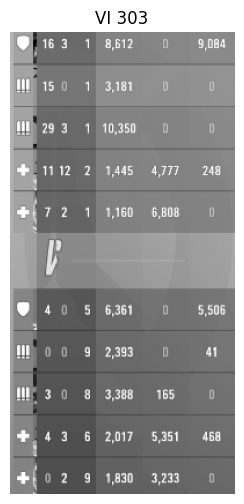

2025-10-15 03:08:47.560209: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.io import decode_png, read_file
import tensorflow as tf
from tensorflow.image import resize
from tensorflow.strings import split, upper, substr, to_number
from tensorflow import int32
from matplotlib.pyplot import figure, title, axis, imshow, show


def load_and_process_image(file_path):
    # PNG 파일을 로드하고 디코딩 (그레이스케일)
    image = decode_png(read_file(file_path), channels=1)

    # 관심 영역(Region of Interest) 자르기
    cropped = image[230:930, 530:1370]

    # 특정 열 부분을 추출하고 이어 붙이기
    columns = (
        cropped[:, :40],  # 왼쪽 여백
        cropped[:, 390:420],  # 문자 1
        cropped[:, 450:480],  # 문자 2
        cropped[:, 500:530],  # 문자 3
        cropped[:, 570:640],  # 문자 4
        cropped[:, 670:740],  # 문자 5
        cropped[:, 770:]  # 오른쪽 여백
    )
    combined = tf.concat(columns, axis=1)  # 가로 방향으로 이어 붙이기

    # 크기 조정 (400x400), 비율 유지
    resized = resize(combined, size=(400, 400), preserve_aspect_ratio=True)

    # 파일 이름에서 메타데이터 추출
    filename_parts = split(file_path, '/')[-1]  # 경로에서 파일 이름만 추출
    parts = split(filename_parts, '_')
    label_str = upper(substr(parts[0], 0, 2))  # 첫 두 글자를 대문자로 변환 (예: 라벨 코드)
    number = to_number(split(parts[1], '.')[0], out_type=int32)  # 숫자 부분 추출 및 정수형 변환

    return resized, label_str, number


def visualize_batch(images, labels, numbers):
    figure(figsize=(6, 6))
    title(f'{labels[0].numpy().decode()} {numbers[0]}')  # 첫 번째 이미지의 라벨과 숫자 표시
    axis('off')
    imshow(images[0], cmap='gray')  # 첫 번째 이미지 표시
    show()


# 데이터셋 생성
dataset = Dataset.list_files('datasets/*/*')  # 모든 하위 폴더의 파일 불러오기
dataset = dataset.map(load_and_process_image, num_parallel_calls=AUTOTUNE)  # 병렬 처리로 이미지 전처리
dataset = dataset.batch(32).prefetch(AUTOTUNE)  # 배치 구성 및 사전 로딩

# 배치 하나 시각화
for images, labels, numbers in dataset.take(1):
    visualize_batch(images, labels, numbers)

In [15]:
X, y = dataset[0]

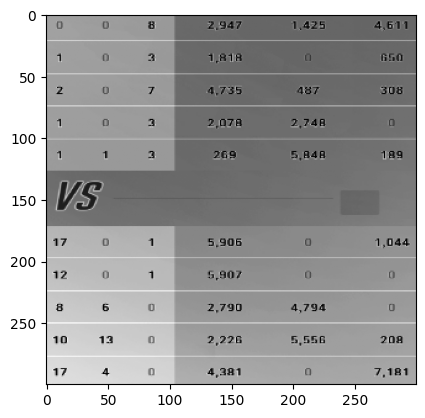

In [16]:
from matplotlib.pyplot import imshow, show

imshow(X[0], 'binary')
show()

In [5]:
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()
X = X_scaler.fit_transform(ndarray_png.reshape(-1, 1)).reshape(-1, 300, 300, 1)
int_outputs = 210
y = frame_column.values.reshape(-1, int_outputs).T
int_slice = -10
X_train, tuple_y_train = X[:int_slice], tuple(y[:, :int_slice])
X_valid, tuple_y_valid = X[int_slice:], tuple(y[:, int_slice:])
X_train.shape, len(tuple_y_train), X_valid.shape, len(tuple_y_valid)

((889, 300, 300, 1), 210, (10, 300, 300, 1), 210)

In [9]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

X_shape = X_train.shape[1:]

In [26]:
clear_session()
inputs = Input(X_shape)
flatten = Flatten()(inputs)
dense_1 = Dense(300, 'relu')(flatten)
dense_2 = Dense(100, 'relu')(dense_1)
outputs = tuple(Dense(10, 'softmax', name=f'dense_3_{i}')(dense_2) for i in range(1, int_outputs + 1))
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 90000)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 300)       │ 27,000,300 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100)       │     30,100 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_1 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_2 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_3 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_4 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_5 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_6 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_7 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_8 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_9 (Dense)   │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_10 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_11 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_12 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_13 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_14 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_15 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_16 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_17 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_18 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_19 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_20 (Dense)  │ (None, 10)        │      1,010 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 27,242,500 (103.92 MB)

 Trainable params: 27,242,500 (103.92 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.callbacks import Callback
from numpy import array


class Logger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(
            f'Epoch {epoch + 1}/{self.params["epochs"]}' +
            f'\nloss: {logs["loss"]:.4f}' +
            f' - accuracy: {array([logs[f"dense_3_{i}_accuracy"] for i in range(1, int_outputs + 1)]).mean():.4f}' +
            f' - val_loss: {logs["val_loss"]:.4f}' +
            f' - val_accuracy: {array([logs[f"val_dense_3_{i}_accuracy"] for i in range(1, int_outputs + 1)]).mean():.4f}'
        )

In [28]:
model.compile('SGD', 'sparse_categorical_crossentropy', metrics=['accuracy'] * int_outputs)
history = model.fit(
    X_train,
    tuple_y_train,
    epochs=1000,
    verbose=0,
    callbacks=(EarlyStopping(patience=10, restore_best_weights=True), Logger()),
    validation_data=(X_valid, tuple_y_valid)
)

2025-09-28 07:37:04.954034: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45412', 12 bytes spill stores, 12 bytes spill loads

2025-09-28 07:37:04.963266: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45412', 12 bytes spill stores, 12 bytes spill loads

2025-09-28 07:37:05.198257: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45412', 12 bytes spill stores, 12 bytes spill loads

2025-09-28 07:37:05.235718: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45412', 12 bytes spill stores, 12 bytes spill loads

2025-09-28 07:37:05.237724: I extern

Epoch 1/1000
loss: 842547986432.0000 - accuracy: 0.2901 - val_loss: 461.0714 - val_accuracy: 0.3181
Epoch 2/1000
loss: 446.5577 - accuracy: 0.3421 - val_loss: 433.7435 - val_accuracy: 0.3571
Epoch 3/1000
loss: 402.9878 - accuracy: 0.3886 - val_loss: 373.7462 - val_accuracy: 0.4124
Epoch 4/1000
loss: 352.2129 - accuracy: 0.4315 - val_loss: 344.7107 - val_accuracy: 0.4248
Epoch 5/1000
loss: 335.7769 - accuracy: 0.4371 - val_loss: 337.0344 - val_accuracy: 0.4219
Epoch 6/1000
loss: 330.0737 - accuracy: 0.4389 - val_loss: 334.0575 - val_accuracy: 0.4181
Epoch 7/1000
loss: 327.5916 - accuracy: 0.4394 - val_loss: 332.8746 - val_accuracy: 0.4181
Epoch 8/1000
loss: 326.4442 - accuracy: 0.4395 - val_loss: 332.0260 - val_accuracy: 0.4190
Epoch 9/1000
loss: 325.8358 - accuracy: 0.4399 - val_loss: 331.3776 - val_accuracy: 0.4219
Epoch 10/1000
loss: 325.4693 - accuracy: 0.4393 - val_loss: 331.3204 - val_accuracy: 0.4181
Epoch 11/1000
loss: 325.2470 - accuracy: 0.4394 - val_loss: 331.2391 - val_accur

In [29]:
y_proba = array(model.predict(X_valid[:1])).argmax(2).reshape(10, 21)
y_proba

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[1, 6, 0, 3, 0, 5, 0, 6, 4, 2, 0, 0, 0, 0, 0, 0, 0, 4, 1, 7, 2],
       [1, 2, 0, 0, 0, 6, 0, 7, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 4, 0, 0, 0, 8, 0, 9, 5, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 4, 0, 5, 0, 3, 1, 4, 0, 0, 8, 1, 7, 6, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 6, 0, 2, 0, 0, 0, 0, 5, 6, 3, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 2, 0, 5, 0, 0, 0, 9, 1, 0, 0, 0, 0, 0, 0, 5, 6, 3, 4],
       [1, 5, 0, 0, 0, 8, 0, 6, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 7, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 1, 8, 0, 5, 0, 3, 0, 0, 0, 0, 6, 4, 4, 4, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 6, 0, 2, 0, 0, 0, 0, 6, 8, 7, 3, 0, 0, 0, 0, 0]])

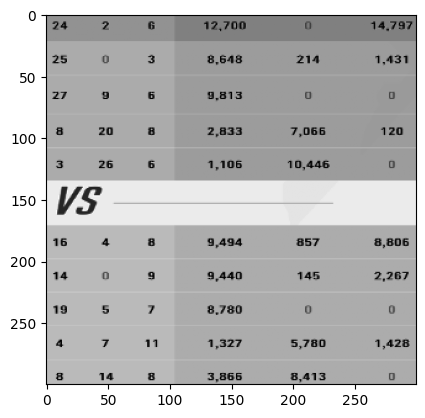

In [30]:
imshow(X_valid[0], 'binary')
show()

In [31]:
array(tuple_y_valid)[:, 0].reshape(10, 21)

array([[2, 4, 0, 2, 0, 6, 1, 2, 7, 0, 0, 0, 0, 0, 0, 0, 1, 4, 7, 9, 7],
       [2, 5, 0, 0, 0, 3, 0, 8, 6, 4, 8, 0, 0, 2, 1, 4, 0, 1, 4, 3, 1],
       [2, 7, 0, 9, 0, 6, 0, 9, 8, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 8, 2, 0, 0, 8, 0, 2, 8, 3, 3, 0, 7, 0, 6, 6, 0, 0, 1, 2, 0],
       [0, 3, 2, 6, 0, 6, 0, 1, 1, 0, 6, 1, 0, 4, 4, 6, 0, 0, 0, 0, 0],
       [1, 6, 0, 4, 0, 8, 0, 9, 4, 9, 4, 0, 0, 8, 5, 7, 0, 8, 8, 0, 6],
       [1, 4, 0, 0, 0, 9, 0, 9, 4, 4, 0, 0, 0, 1, 4, 5, 0, 2, 2, 6, 7],
       [1, 9, 0, 5, 0, 7, 0, 8, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 7, 1, 1, 0, 1, 3, 2, 7, 0, 5, 7, 8, 0, 0, 1, 4, 2, 8],
       [0, 8, 1, 4, 0, 8, 0, 3, 8, 6, 6, 0, 8, 4, 1, 3, 0, 0, 0, 0, 0]])

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout

clear_session()
input_ = Input(X_shape)
conv_2d_1 = Conv2D(64, 7, padding='same', activation='relu', kernel_initializer='HeNormal')(input_)
max_pool_2d_1 = MaxPool2D()(conv_2d_1)
conv_2d_2 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='HeNormal')(max_pool_2d_1)
conv_2d_3 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='HeNormal')(conv_2d_2)
max_pool_2d_2 = MaxPool2D()(conv_2d_3)
conv_2d_4 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='HeNormal')(max_pool_2d_2)
conv_2d_5 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='HeNormal')(conv_2d_4)
max_pool_2d_3 = MaxPool2D()(conv_2d_5)
flatten = Flatten()(max_pool_2d_3)
dense_1 = Dense(128, 'relu', kernel_initializer='HeNormal')(flatten)
dropout_1 = Dropout(.5)(dense_1)
dense_2 = Dense(64, 'relu', kernel_initializer='HeNormal')(dropout_1)
dropout_2 = Dropout(.5)(dense_2)
dense_3 = [Dense(10, 'softmax', name=f'dense_3_{i}')(dropout_2) for i in range(1, int_outputs + 1)]
model = Model(inputs=input_, outputs=dense_3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 300, 300,  │      3,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 150, 150,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 150, 150,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 150, 150,  │    147,584 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 75, 75,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 75, 75,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 75, 75,    │    590,080 │ conv2d_3[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 37, 37,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 350464)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 44,859,520 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_1 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_2 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_3 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_4 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_5 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_6 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_7 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3_8 (Dense)   │ (None, 10)        │      1,290 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 46,240,308 (176.39 MB)

 Trainable params: 46,240,308 (176.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile('nadam', 'sparse_categorical_crossentropy', metrics=['accuracy'] * int_outputs)
history = model.fit(
    X_train,
    tuple_y_train,
    16,
    epochs=1000,
    verbose=0,
    callbacks=(EarlyStopping(patience=10, restore_best_weights=True), Logger()),
    validation_data=(X_valid, tuple_y_valid)
)

Epoch 1/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 2/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 3/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 4/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 5/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 6/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 7/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 8/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 9/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 10/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543
Epoch 11/1000
loss: nan - accuracy: nan - val_loss: nan - val_accuracy: 0.0543


F0000 00:00:1759046499.642028    7704 bfc_allocator.cc:719] Check failed: h != kInvalidChunkHandle 
